In [43]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import warnings
import tensorflow as tf
import seaborn as sns
import sklearn
import random
import math
import time
import shap


from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
from scipy import optimize
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap

from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
from methods import *

%matplotlib inline
warnings.filterwarnings('ignore')

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

# FD001

In [44]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD001.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
#                     'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
remaining_sensors = ["Ps30", "Nf", "P30", "BPR"] # selection based on main_notebook
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 120
train['RUL'].clip(upper=rul_piecewise, inplace=True)

## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(20631, 27) (13096, 26) (100, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,-0.0,-0.0,100.0,0.0,0.168712,0.419699,0.281998,0.0,...,0.186883,0.364675,0.0,0.333333,0.0,0.0,0.779661,0.750000,120,-0.0_-0.0_100.0
1,1,2,0.0,-0.0,100.0,0.0,0.231676,0.437236,0.301955,0.0,...,0.180816,0.382647,0.0,0.301435,0.0,0.0,0.749952,0.736399,120,0.0_-0.0_100.0
2,1,3,-0.0,0.0,100.0,0.0,0.279270,0.414066,0.334500,0.0,...,0.168127,0.371184,0.0,0.227105,0.0,0.0,0.713728,0.699766,120,-0.0_0.0_100.0
3,1,4,0.0,0.0,100.0,0.0,0.295582,0.363296,0.318775,0.0,...,0.168159,0.315365,0.0,0.266806,0.0,0.0,0.671042,0.684862,120,0.0_0.0_100.0
4,1,5,-0.0,-0.0,100.0,0.0,0.305799,0.336489,0.335855,0.0,...,0.166419,0.338028,0.0,0.310184,0.0,0.0,0.664455,0.695191,120,-0.0_-0.0_100.0


In [45]:
# 1layers
def model_lstm_1layer(input_shape, nodes_per_layer, dropout, activation):
    
    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    model = Sequential()
    model.add(LSTM(units = nodes_per_layer, activation=activation, 
                  input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(256))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=0.001))
    # model.save_weights(weights_file)

    return model

In [46]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 21	13.768992	0.0	3.830708e+02	0.0	189.585159	0.0	0.10	[128]	0.2	tanh	64	30
results001 = pd.DataFrame()

for SEED in range(1):  
    set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.1
    sequence_length = 30
    epochs = 30
    nodes_per_layer = [128]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 64
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results001 = pd.concat([results001, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results001.to_csv('results/base/fd001.csv')

(17731, 30, 4) (17731, 1) (100, 30, 4)
Epoch 1/30
278/278 [==============================] - 4s 11ms/step - loss: 1944.5961 - val_loss: 1542.0682
Epoch 2/30
278/278 [==============================] - 3s 11ms/step - loss: 1115.9581 - val_loss: 699.7667
Epoch 3/30
278/278 [==============================] - 3s 11ms/step - loss: 638.8581 - val_loss: 426.3709
Epoch 4/30
278/278 [==============================] - 3s 11ms/step - loss: 387.9904 - val_loss: 209.8593
Epoch 5/30
278/278 [==============================] - 3s 11ms/step - loss: 298.0899 - val_loss: 229.3895
Epoch 6/30
278/278 [==============================] - 3s 10ms/step - loss: 271.9521 - val_loss: 200.8959
Epoch 7/30
278/278 [==============================] - 3s 13ms/step - loss: 267.7080 - val_loss: 194.5271
Epoch 8/30
278/278 [==============================] - 3s 10ms/step - loss: 259.6712 - val_loss: 319.8610
Epoch 9/30
278/278 [==============================] - 3s 10ms/step - loss: 255.7187 - val_loss: 185.4786
Epoch 10/30
2

In [47]:
results001

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,14.755003,0.0,302.835148,0.0,217.710098,0.0,[128],0.2,tanh,64,30,105.7569


In [48]:
import shap
class LSTMModelWrapper:
    def __init__(self, model, input_shape):
        """
        Wrapper for LSTM models to work with SHAP.

        Parameters:
        - model: Trained LSTM model.
        - input_shape: Tuple (timesteps, features) of the original model input shape.
        """
        self.model = model
        self.timesteps, self.features = input_shape

    def predict(self, X_flat):
        """
        Predict function for SHAP that reshapes flat input back to 3D.

        Parameters:
        - X_flat: 2D numpy array [samples, timesteps * features].

        Returns:
        - Predictions from the LSTM model.
        """
        # Reshape to 3D: [samples, timesteps, features]
        X_reshaped = X_flat.reshape(-1, self.timesteps, self.features)
        return self.model.predict(X_reshaped)

def explain_lstm_model(model, X_train, X_test, timesteps, features):
    """
    Explains an LSTM model using SHAP.

    Parameters:
    - model: Trained LSTM model.
    - X_train: Training data in 3D shape [samples, timesteps, features].
    - X_test: Test data in 3D shape [samples, timesteps, features].
    - timesteps: Number of timesteps for the LSTM model input.
    - features: Number of features for the LSTM model input.

    Returns:
    - SHAP values for the test data.
    """
    # Flatten training and testing data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Wrap the LSTM model
    lstm_wrapper = LSTMModelWrapper(model, (timesteps, features))

    # Use SHAP KernelExplainer
    explainer = shap.KernelExplainer(lstm_wrapper.predict, X_train_flat[:10])  # Use a subset for background data
    shap_values = explainer.shap_values(X_test_flat)

    return shap_values, explainer

def reshape_shap_values(shap_values, original_shape):
    """
    Reshape SHAP values to match the original input shape.

    Parameters:
        shap_values (np.ndarray): SHAP values, typically a 2D array.
        original_shape (tuple): Desired shape, typically (samples, timesteps, features).

    Returns:
        np.ndarray: Reshaped SHAP values.
    """
    # Vérifiez que le produit des dimensions correspond
    if shap_values.shape[1] != np.prod(original_shape[1:]):
        raise ValueError("SHAP values cannot be reshaped to the desired shape. Check dimensions.")
    
    # Reshape des SHAP values
    reshaped_shap = shap_values.reshape(original_shape)
    return reshaped_shap

In [49]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

test_array_susbset = test_array[0:4]
test_array_susbset.shape

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:100], test_array_susbset, timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array_susbset.reshape(test_array_susbset.shape[0], -1))

# shap_values.shape
samples = shap_values.shape[0]
features = len(remaining_sensors)
list_of_shapes = [shap_values[i].reshape(-1,features) for i in range(samples)]

1/1 [==============================] - 0s 23ms/step


  0%|          | 0/4 [00:00<?, ?it/s]

715/715 [==============================] - 3s 4ms/step


 25%|██▌       | 1/4 [00:03<00:10,  3.58s/it]

715/715 [==============================] - 3s 4ms/step


 50%|█████     | 2/4 [00:09<00:09,  4.88s/it]

715/715 [==============================] - 3s 4ms/step


 75%|███████▌  | 3/4 [00:15<00:05,  5.30s/it]

715/715 [==============================] - 4s 6ms/step


100%|██████████| 4/4 [00:19<00:00,  4.90s/it]


In [50]:
# # Dimensions originales
# samples = 1
# # timesteps = 30
# # features = 5

# # SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
# shap_values_flat = np.random.rand(samples, timesteps * features)

# # Dimensions originales des données
# original_shape = (samples, timesteps, features)

# # Reshape des SHAP values
# shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
# print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)

# list_shap_values = []
# for i in range(samples):
#     shap_values_2D = shap_values[i].reshape(-1,features)
#     list_shap_values.append(np.abs(shap_values_2D).sum(axis=0))  # Somme sur samples et timesteps
# somme_abs_par_feature001 = np.array(list_shap_values).sum(axis = 0)
# remaining_sensors001 = remaining_sensors
# somme_abs_par_feature001


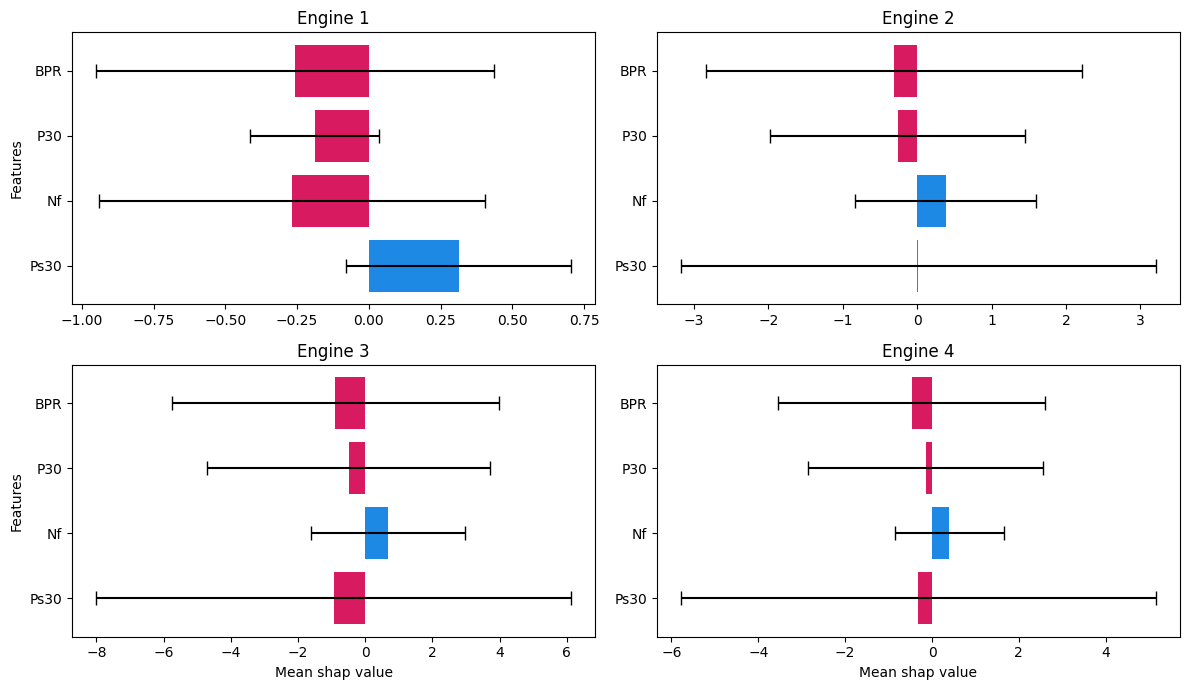

In [51]:
# Calcul de la moyenne et de l'écart-type
lis_df_shap = []
for i, shap_values_2D in enumerate(list_of_shapes):
    # plt.subplot(2,2,i+1)
    shap_values_squeeze = shap_values_2D
    mean_shap = shap_values_squeeze.mean(axis=0)
    std_shap = shap_values_squeeze.std(axis=0)

    # Création des noms de variables
    column_names = remaining_sensors

    # DataFrame
    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap,
        "SHAP Std": std_shap
    })

    # Couleurs SHAP standards
    shap_blue = '#1E88E5'
    shap_red = '#D81B60'

    # Choix de la couleur selon le signe
    shap_df["Couleur"] = shap_df["SHAP Value"].apply(lambda x: shap_blue if x >= 0 else shap_red)
    lis_df_shap.append(shap_df)

plt.figure(figsize=(12, 7))
for kk, shap_df in enumerate(lis_df_shap):
    # print(kk)
    plt.subplot(2,2, kk+1)
    # Tracé des barres une par une avec la bonne couleur
    # plt.figure(figsize=(6, len(shap_df) * 0.6))
    for i, row in shap_df.iterrows():
        plt.barh(
            y=row["Variable"],
            width=row["SHAP Value"],
            xerr=row["SHAP Std"],
            color=row["Couleur"],
            # edgecolor='black',
            capsize=5
        )
    if kk>1:
        plt.xlabel("Mean shap value")
    if (kk+1)%2!=0:
        plt.ylabel("Features")
    plt.title(f"Engine {kk+1}")
    plt.tight_layout()
plt.savefig("images/fd001_shape_std.png")
plt.show()

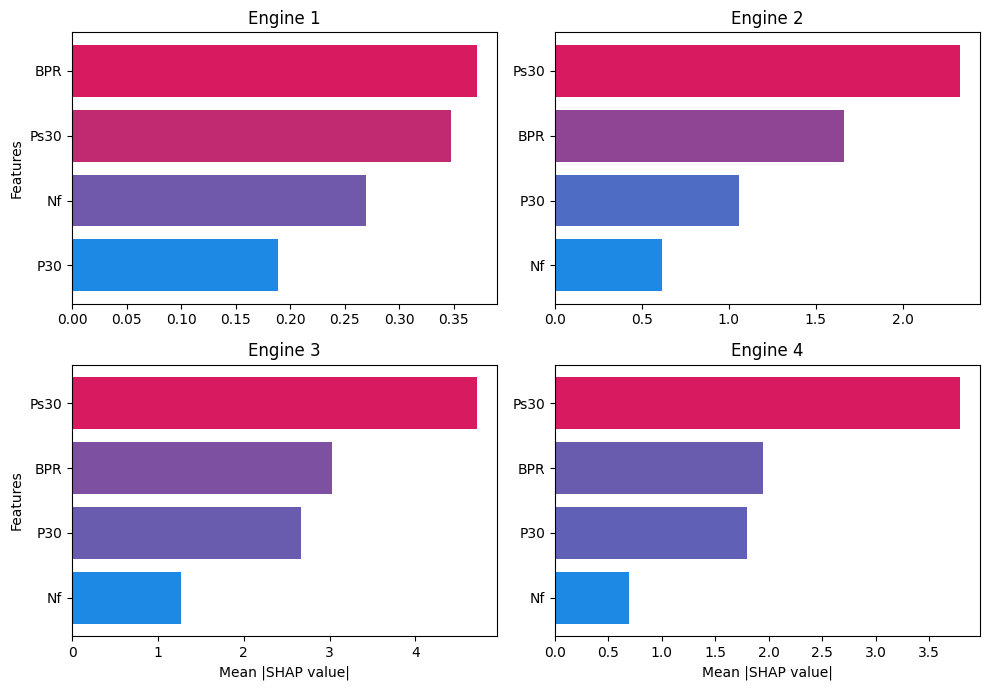

In [52]:
# Dégradé bleu → rouge (faible → fort)
custom_cmap = LinearSegmentedColormap.from_list("shap_cmap", ['#1E88E5', '#D81B60'])

lis_df_shap = []
for i, shap_values_2D in enumerate(list_of_shapes):
    shap_values_squeeze = shap_values_2D
    mean_shap = np.abs(shap_values_squeeze).mean(axis=0)

    column_names = remaining_sensors

    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap
    })

    # Tri décroissant
    shap_df = shap_df.sort_values("SHAP Value", ascending=False).reset_index(drop=True)

    # Normalisation des valeurs entre 0 et 1 pour le dégradé
    norm = plt.Normalize(shap_df["SHAP Value"].min(), shap_df["SHAP Value"].max())
    shap_df["Couleur"] = [custom_cmap(norm(val)) for val in shap_df["SHAP Value"]]

    lis_df_shap.append(shap_df)

# Affichage
plt.figure(figsize=(10, 7))
for kk, shap_df in enumerate(lis_df_shap):
    plt.subplot(2, 2, kk + 1)

    for i, row in enumerate(shap_df.itertuples()):
        plt.barh(
            y=i,
            width=row._2,  # SHAP Value
            color=row.Couleur,
            #  height=0.6,
            # edgecolor='black'
        )

    # Axe Y
    plt.yticks(ticks=range(len(shap_df)), labels=shap_df["Variable"])
    plt.gca().invert_yaxis()

    if kk > 1:
        plt.xlabel("Mean |SHAP value|")
    if (kk + 1) % 2 != 0:
        plt.ylabel("Features")

    plt.title(f"Engine {kk + 1}")

plt.tight_layout()
plt.savefig("images/fd001_shape_abs.png")
plt.show()

In [53]:
# from PyALE import ale
# import numpy as np
# import pandas as pd

# class LSTMModelWrapper:
#     def __init__(self, model, input_shape):
#         self.model = model
#         self.timesteps, self.features = input_shape

#     def predict(self, X_flat):
#         if isinstance(X_flat, pd.DataFrame):
#             X_flat = X_flat.values  # Convertit en numpy array
#         X_reshaped = X_flat.reshape(-1, self.timesteps, self.features)
#         return self.model.predict(X_reshaped).squeeze()


# # Données d'entrée
# X_train_flat = train_array.reshape(train_array.shape[0], -1)
# X_test_flat = test_array.reshape(test_array.shape[0], -1)
# input_shape = (train_array.shape[1], train_array.shape[2])  # (timesteps, features)

# # Modèle wrappé
# model_wrapper = LSTMModelWrapper(model, input_shape)

# # Exemple : analyse ALE pour la variable 'feature_3 at timestep_5'
# # On crée un DataFrame avec des noms explicites pour chaque colonne
# feature_names = [f"f{f}_t{t}" for t in range(input_shape[0]) for f in remaining_sensors]
# X_df = pd.DataFrame(X_train_flat, columns=feature_names)

# # Choisir une variable (par exemple : capteur 3 à timestep 5)
# target_feature = ["fP30_t3"]

# # Appliquer ALE
# ale_effet = ale(
#     X=X_df,
#     model=model_wrapper,
#     feature=target_feature,
#     feature_type="continuous",
#     include_CI=True,  # pour avoir les barres de confiance
#     grid_size=20
# )

# # Visualisation automatique
# # ou plt.plot(ale_effet["quantiles"], ale_effet["ale_values"])

In [54]:
# # Convertir les données en DataFrame pour faciliter le tri
# plt.figure(figsize=(15, 12))
# for i in range(4) : 
#     e1 = shap_values_reshaped[i:i+1, :, :]
#     somme_abs_par_feature = np.abs(e1).sum(axis=(0, 1))  # Somme sur samples et timesteps
#     # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


#     df_features = pd.DataFrame({
#         "Feature": remaining_sensors,
#         "Importance": somme_abs_par_feature
#     })

#     # Trier les données par importance décroissante
#     df_features = df_features.sort_values(by="Importance", ascending=False)
#     plt.subplot(2,2, i+1)
#     # Création du barplot ordonné
#     sns.barplot(
#         x="Importance",
#         y="Feature",
#         data=df_features,
#         palette="viridis"
#     )
#     plt.xlabel(f"Features Importance According to SHAP for Engine {i+1} ")
#     plt.ylabel("Features")
#     plt.title("SHAP Features Importance (absolute Values)")
# plt.savefig('images/shap_value001.png')
# plt.show()


### FD002

In [55]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD002.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                    # 'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
remaining_sensors = ["Ps30", "Nf", "phi", "epr"] # selection based on main_notebook [1] "Nf" [1] "Ps30" [1] "phi"

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 120
train['RUL'].clip(upper=rul_piecewise, inplace=True)
# ## Data cleaning
alpha = 0.3
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(53759, 27) (33991, 26) (259, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,35.0,0.84,100.0,0.0,0.325733,0.271554,0.561254,0.0,...,0.052796,0.497413,0.0,0.400000,0.0,0.0,0.373494,0.323963,120,35.0_0.84_100.0
1,1,2,42.0,0.84,100.0,0.0,0.447218,0.357533,0.470959,0.0,...,0.095143,0.456428,0.0,0.360784,0.0,0.0,0.309302,0.391651,120,42.0_0.84_100.0
2,1,3,25.0,0.62,60.0,0.0,0.553232,0.355037,0.466030,0.0,...,0.110085,0.414226,0.0,0.470015,0.0,0.0,0.286071,0.531223,120,25.0_0.62_60.0
3,1,4,42.0,0.84,100.0,0.0,0.495285,0.387258,0.447732,0.0,...,0.107374,0.381830,0.0,0.372189,0.0,0.0,0.359184,0.632675,120,42.0_0.84_100.0
4,1,5,25.0,0.62,60.0,0.0,0.528642,0.383824,0.455578,0.0,...,0.104597,0.378322,0.0,0.454340,0.0,0.0,0.343109,0.552861,120,25.0_0.62_60.0


In [56]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 16.603718	0.0	1.343367e+03	0.0	275.683502	0.0	0.20	[32]	0.1	tanh	128	40
results002 = pd.DataFrame()

for SEED in range(1):  
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.2
    sequence_length = 40
    epochs = 50
    nodes_per_layer = [32]
    dropout = 0.1
    activation = 'tanh'
    batch_size = 128
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results002 = pd.concat([results002, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results002.to_csv('results/base/fd002.csv')

(43619, 40, 4) (43619, 1) (259, 40, 4)
Epoch 1/50
341/341 [==============================] - 5s 12ms/step - loss: 2214.2354 - val_loss: 1642.6108
Epoch 2/50
341/341 [==============================] - 4s 11ms/step - loss: 1018.1802 - val_loss: 488.0606
Epoch 3/50
341/341 [==============================] - 4s 12ms/step - loss: 399.2461 - val_loss: 359.0230
Epoch 4/50
341/341 [==============================] - 4s 11ms/step - loss: 347.6960 - val_loss: 342.8446
Epoch 5/50
341/341 [==============================] - 6s 17ms/step - loss: 326.0885 - val_loss: 276.4044
Epoch 6/50
341/341 [==============================] - 3s 10ms/step - loss: 318.6015 - val_loss: 284.3752
Epoch 7/50
341/341 [==============================] - 3s 10ms/step - loss: 312.9294 - val_loss: 288.9886
Epoch 8/50
341/341 [==============================] - 4s 12ms/step - loss: 307.7955 - val_loss: 307.5814
Epoch 9/50
341/341 [==============================] - 4s 11ms/step - loss: 298.9600 - val_loss: 309.4959
Epoch 10/50
3

In [57]:
results002

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,14.711434,0.0,1082.988826,0.0,216.4263,0.0,[32],0.1,tanh,128,40,196.072


##### Generation de shap shap values

In [58]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

test_array_susbset = test_array[0:4]
test_array_susbset.shape

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:100], test_array_susbset, timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array_susbset.reshape(test_array_susbset.shape[0], -1))

# shap_values.shape
samples = shap_values.shape[0]
features = len(remaining_sensors)
list_of_shapes = [shap_values[i].reshape(-1,features) for i in range(samples)]


1/1 [==============================] - 0s 17ms/step


  0%|          | 0/4 [00:00<?, ?it/s]

740/740 [==============================] - 2s 2ms/step


 25%|██▌       | 1/4 [00:02<00:07,  2.55s/it]

740/740 [==============================] - 2s 2ms/step


 50%|█████     | 2/4 [00:05<00:05,  2.65s/it]

740/740 [==============================] - 2s 3ms/step


 75%|███████▌  | 3/4 [00:08<00:02,  2.74s/it]

740/740 [==============================] - 2s 3ms/step


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


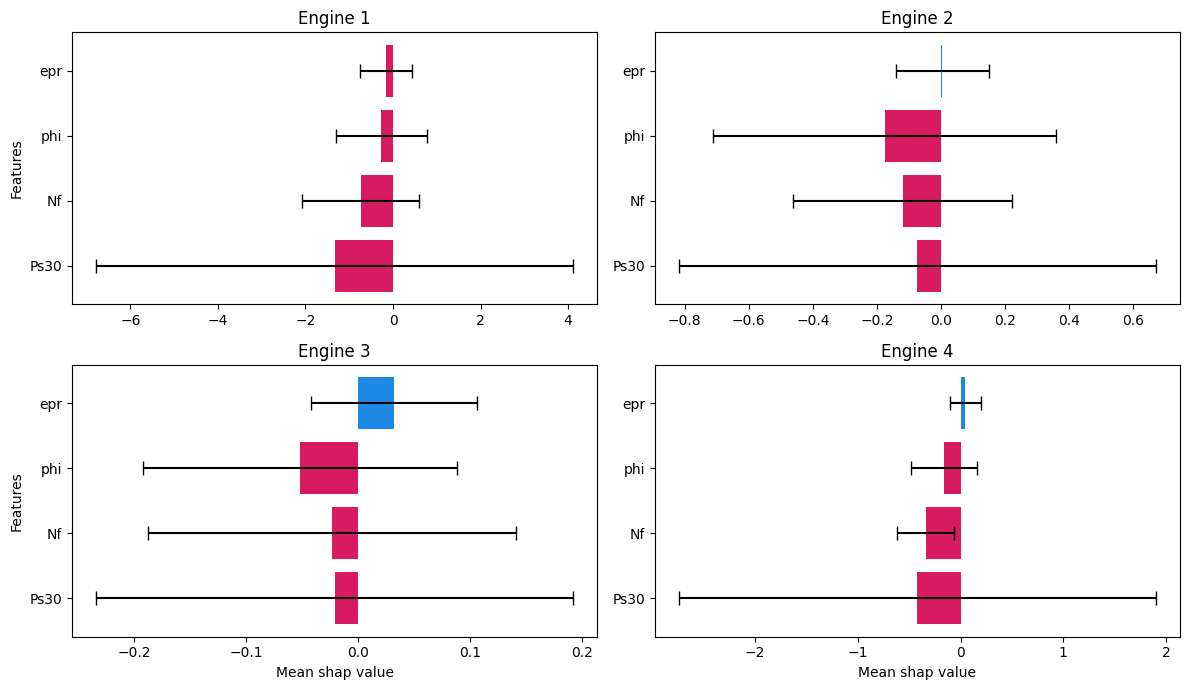

In [59]:
# Calcul de la moyenne et de l'écart-type
lis_df_shap = []
for i, shap_values_2D in enumerate(list_of_shapes):
    # plt.subplot(2,2,i+1)
    shap_values_squeeze = shap_values_2D
    mean_shap = shap_values_squeeze.mean(axis=0)
    std_shap = shap_values_squeeze.std(axis=0)

    # Création des noms de variables
    column_names = remaining_sensors

    # DataFrame
    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap,
        "SHAP Std": std_shap
    })

    # Couleurs SHAP standards
    shap_blue = '#1E88E5'
    shap_red = '#D81B60'

    # Choix de la couleur selon le signe
    shap_df["Couleur"] = shap_df["SHAP Value"].apply(lambda x: shap_blue if x >= 0 else shap_red)
    lis_df_shap.append(shap_df)

plt.figure(figsize=(12, 7))
for kk, shap_df in enumerate(lis_df_shap):
    # print(kk)
    plt.subplot(2,2, kk+1)
    # Tracé des barres une par une avec la bonne couleur
    # plt.figure(figsize=(6, len(shap_df) * 0.6))
    for i, row in shap_df.iterrows():
        plt.barh(
            y=row["Variable"],
            width=row["SHAP Value"],
            xerr=row["SHAP Std"],
            color=row["Couleur"],
            # edgecolor='black',
            capsize=5
        )
    if kk>1:
        plt.xlabel("Mean shap value")
    if (kk+1)%2!=0:
        plt.ylabel("Features")
    plt.title(f"Engine {kk+1}")
    plt.tight_layout()
plt.savefig("images/fd002_shape_std.png")
plt.show()

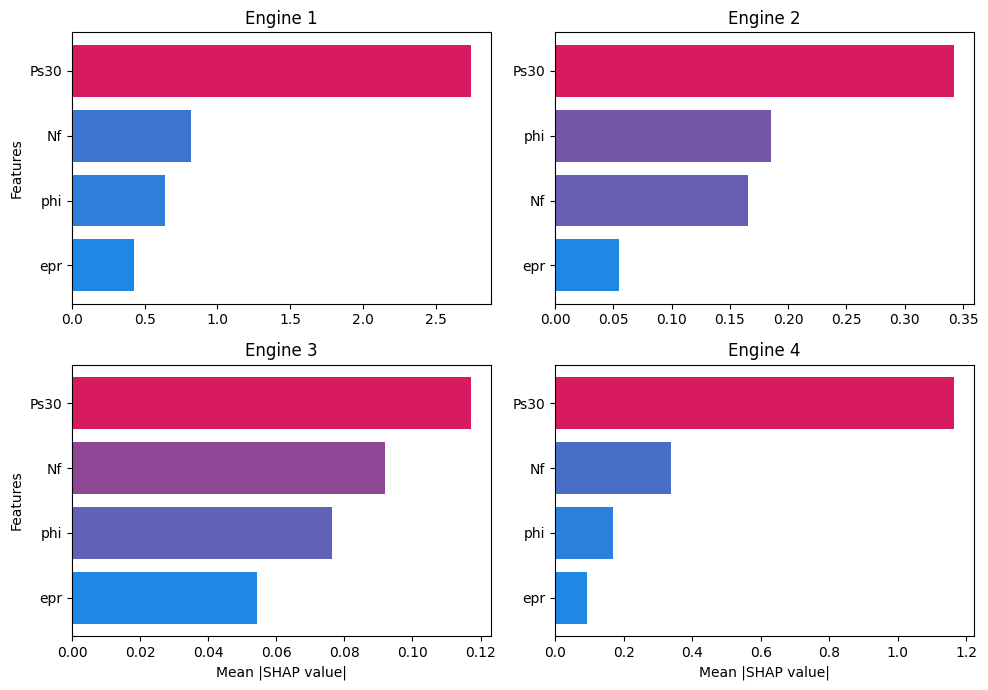

In [60]:
# Dégradé bleu → rouge (faible → fort)
custom_cmap = LinearSegmentedColormap.from_list("shap_cmap", ['#1E88E5', '#D81B60'])

lis_df_shap = []
for i, shap_values_2D in enumerate(list_of_shapes):
    shap_values_squeeze = shap_values_2D
    mean_shap = np.abs(shap_values_squeeze).mean(axis=0)

    column_names = remaining_sensors

    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap
    })

    # Tri décroissant
    shap_df = shap_df.sort_values("SHAP Value", ascending=False).reset_index(drop=True)

    # Normalisation des valeurs entre 0 et 1 pour le dégradé
    norm = plt.Normalize(shap_df["SHAP Value"].min(), shap_df["SHAP Value"].max())
    shap_df["Couleur"] = [custom_cmap(norm(val)) for val in shap_df["SHAP Value"]]

    lis_df_shap.append(shap_df)

# Affichage
plt.figure(figsize=(10, 7))
for kk, shap_df in enumerate(lis_df_shap):
    plt.subplot(2, 2, kk + 1)

    for i, row in enumerate(shap_df.itertuples()):
        plt.barh(
            y=i,
            width=row._2,  # SHAP Value
            color=row.Couleur,
            #  height=0.6,
            # edgecolor='black'
        )

    # Axe Y
    plt.yticks(ticks=range(len(shap_df)), labels=shap_df["Variable"])
    plt.gca().invert_yaxis()

    if kk > 1:
        plt.xlabel("Mean |SHAP value|")
    if (kk + 1) % 2 != 0:
        plt.ylabel("Features")

    plt.title(f"Engine {kk + 1}")

plt.tight_layout()
plt.savefig("images/fd002_shape_abs.png")
plt.show()

#### FD003

In [61]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD003.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
#                     'NRf','NRc','BPR','htBleed','W31','W32']
remaining_sensors = ["Ps30", "NRc", "W31", "BPR"] # selection based on main_notebook [1] "Nf" [1] "Ps30" [1] "phi"

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 125
train['RUL'].clip(upper=rul_piecewise, inplace=True)
## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(24720, 27) (16596, 26) (100, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,-0.0,0.0,100.0,0.0,0.378788,0.341211,0.279748,0.0,...,0.238238,0.618635,0.0,0.272727,0.0,0.0,0.546584,0.469595,125,-0.0_0.0_100.0
1,1,2,0.0,-0.0,100.0,0.0,0.403623,0.371855,0.295333,0.0,...,0.270487,0.639660,0.0,0.320574,0.0,0.0,0.515568,0.505576,125,0.0_-0.0_100.0
2,1,3,-0.0,-0.0,100.0,0.0,0.376607,0.365007,0.349504,0.0,...,0.273559,0.596319,0.0,0.302918,0.0,0.0,0.478323,0.472777,125,-0.0_-0.0_100.0
3,1,4,-0.0,0.0,100.0,0.0,0.426586,0.372434,0.306566,0.0,...,0.265180,0.574722,0.0,0.320574,0.0,0.0,0.471081,0.455219,125,-0.0_0.0_100.0
4,1,5,0.0,0.0,100.0,0.0,0.370454,0.395376,0.307426,0.0,...,0.268241,0.570330,0.0,0.331090,0.0,0.0,0.495162,0.473204,125,0.0_0.0_100.0


In [62]:
%%time

# 	RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 43	15.404917	0.0	8.255290e+02	0.0	237.311462	0.0	0.10	[64]	0.2	tanh	32	35
results003 = pd.DataFrame()

for SEED in range(1):
    SEED = 1
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    # weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.1
    sequence_length = 35
    epochs = 40
    nodes_per_layer = [64]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 32
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
       
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results003 = pd.concat([results003, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results003.to_csv('results/base/fd003.csv')

(21320, 35, 4) (21320, 1) (100, 35, 4)
Epoch 1/40
667/667 [==============================] - 7s 8ms/step - loss: 1926.2242 - val_loss: 626.0947
Epoch 2/40
667/667 [==============================] - 5s 8ms/step - loss: 509.8139 - val_loss: 495.4820
Epoch 3/40
667/667 [==============================] - 5s 8ms/step - loss: 446.2320 - val_loss: 526.9447
Epoch 4/40
667/667 [==============================] - 5s 8ms/step - loss: 388.7859 - val_loss: 543.0040
Epoch 5/40
667/667 [==============================] - 5s 8ms/step - loss: 350.8421 - val_loss: 445.9988
Epoch 6/40
667/667 [==============================] - 5s 8ms/step - loss: 337.5993 - val_loss: 432.8873
Epoch 7/40
667/667 [==============================] - 6s 10ms/step - loss: 327.3005 - val_loss: 467.6749
Epoch 8/40
667/667 [==============================] - 5s 8ms/step - loss: 308.2838 - val_loss: 336.4559
Epoch 9/40
667/667 [==============================] - 7s 10ms/step - loss: 305.0323 - val_loss: 374.2013
Epoch 10/40
667/667 [=

In [63]:
results003

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,15.549646,0.0,1355.01579,0.0,241.791489,0.0,[64],0.2,tanh,32,35,276.447421


### Shap explanation Generation

1/1 [==============================] - 0s 29ms/step


  0%|          | 0/4 [00:00<?, ?it/s]

728/728 [==============================] - 5s 6ms/step


 25%|██▌       | 1/4 [00:05<00:17,  5.85s/it]

728/728 [==============================] - 5s 7ms/step


 50%|█████     | 2/4 [00:12<00:12,  6.30s/it]

728/728 [==============================] - 6s 8ms/step


 75%|███████▌  | 3/4 [00:19<00:06,  6.71s/it]

728/728 [==============================] - 4s 6ms/step


100%|██████████| 4/4 [00:24<00:00,  6.21s/it]


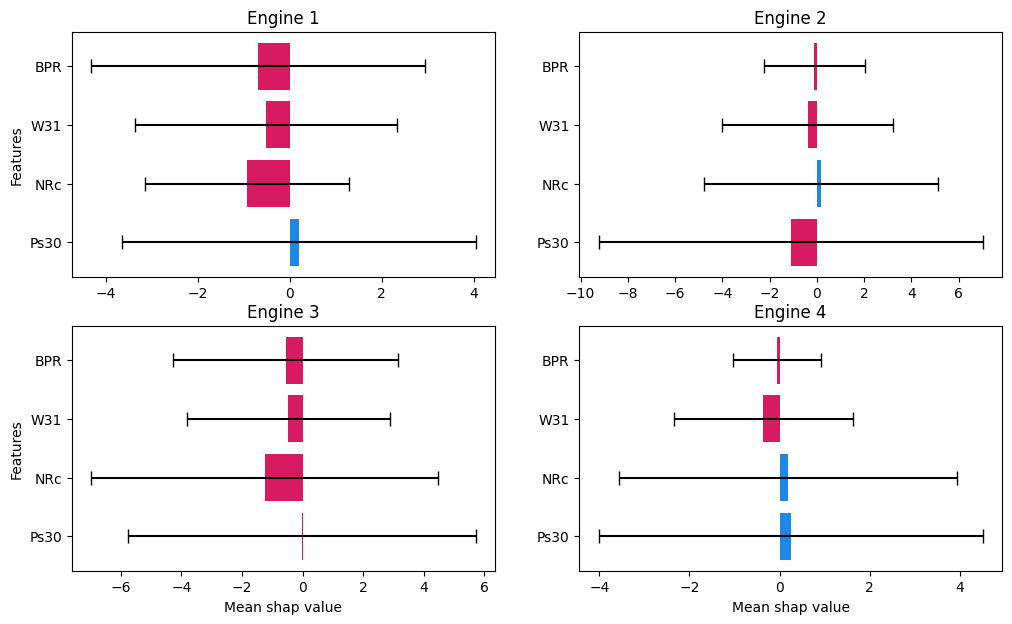

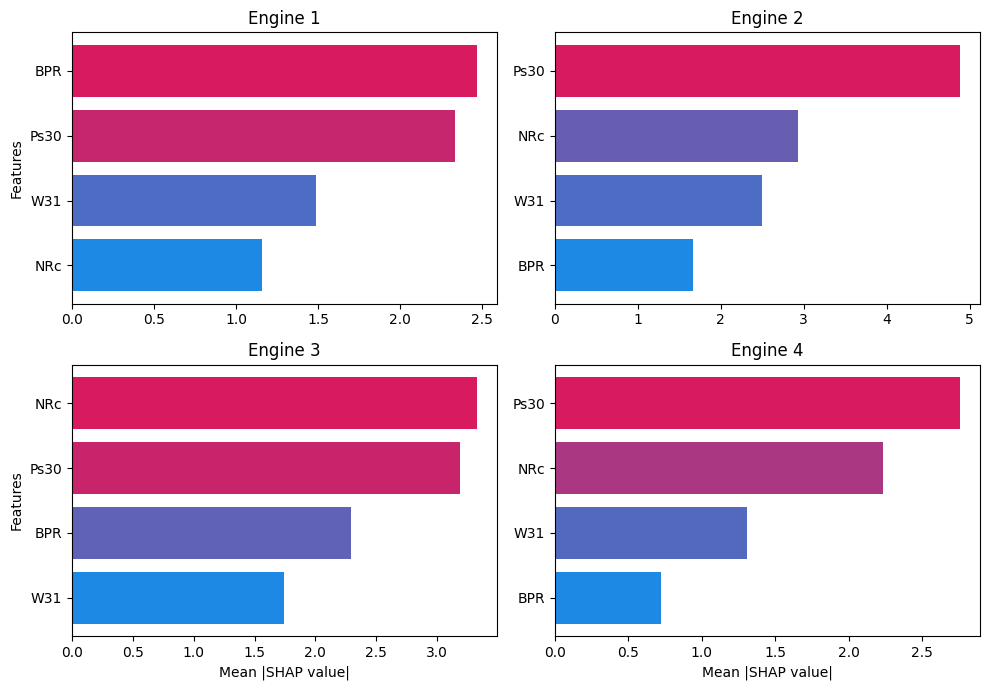

In [64]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

test_array_susbset = test_array[0:4]
test_array_susbset.shape

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:100], test_array_susbset, timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array_susbset.reshape(test_array_susbset.shape[0], -1))

# shap_values.shape
samples = shap_values.shape[0]
features = len(remaining_sensors)
list_of_shapes = [shap_values[i].reshape(-1,features) for i in range(samples)]


##explain with sign
# Calcul de la moyenne et de l'écart-type
lis_df_shap = []
for i, shap_values_2D in enumerate(list_of_shapes):
    # plt.subplot(2,2,i+1)
    shap_values_squeeze = shap_values_2D
    mean_shap = shap_values_squeeze.mean(axis=0)
    std_shap = shap_values_squeeze.std(axis=0)

    # Création des noms de variables
    column_names = remaining_sensors

    # DataFrame
    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap,
        "SHAP Std": std_shap
    })

    # Couleurs SHAP standards
    shap_blue = '#1E88E5'
    shap_red = '#D81B60'

    # Choix de la couleur selon le signe
    shap_df["Couleur"] = shap_df["SHAP Value"].apply(lambda x: shap_blue if x >= 0 else shap_red)
    lis_df_shap.append(shap_df)

plt.figure(figsize=(12, 7))
for kk, shap_df in enumerate(lis_df_shap):
    # print(kk)
    plt.subplot(2,2, kk+1)
    # Tracé des barres une par une avec la bonne couleur
    # plt.figure(figsize=(6, len(shap_df) * 0.6))
    for i, row in shap_df.iterrows():
        plt.barh(
            y=row["Variable"],
            width=row["SHAP Value"],
            xerr=row["SHAP Std"],
            color=row["Couleur"],
            # edgecolor='black',
            capsize=5
        )
    if kk>1:
        plt.xlabel("Mean shap value")
    if (kk+1)%2!=0:
        plt.ylabel("Features")
    plt.title(f"Engine {kk+1}")
    # plt.tight_layout()
plt.savefig("images/fd003_shape_std.png")

plt.show()

#explain without sign

# Dégradé bleu → rouge (faible → fort)
custom_cmap = LinearSegmentedColormap.from_list("shap_cmap", ['#1E88E5', '#D81B60'])

lis_df_shap = []
for i, shap_values_2D in enumerate(list_of_shapes):
    shap_values_squeeze = shap_values_2D
    mean_shap = np.abs(shap_values_squeeze).mean(axis=0)

    column_names = remaining_sensors

    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap
    })

    # Tri décroissant
    shap_df = shap_df.sort_values("SHAP Value", ascending=False).reset_index(drop=True)

    # Normalisation des valeurs entre 0 et 1 pour le dégradé
    norm = plt.Normalize(shap_df["SHAP Value"].min(), shap_df["SHAP Value"].max())
    shap_df["Couleur"] = [custom_cmap(norm(val)) for val in shap_df["SHAP Value"]]

    lis_df_shap.append(shap_df)

# Affichage
plt.figure(figsize=(10, 7))
for kk, shap_df in enumerate(lis_df_shap):
    plt.subplot(2, 2, kk + 1)

    for i, row in enumerate(shap_df.itertuples()):
        plt.barh(
            y=i,
            width=row._2,  # SHAP Value
            color=row.Couleur,
            #  height=0.6,
            # edgecolor='black'
        )

    # Axe Y
    plt.yticks(ticks=range(len(shap_df)), labels=shap_df["Variable"])
    plt.gca().invert_yaxis()

    if kk > 1:
        plt.xlabel("Mean |SHAP value|")
    if (kk + 1) % 2 != 0:
        plt.ylabel("Features")

    plt.title(f"Engine {kk + 1}")

plt.tight_layout()
plt.savefig("images/fd003_shape_abs.png")
plt.show()

### FD004

In [65]:
# Load data
# Load data and preprocess
train, test, y_test = prepare_data('FD004.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

# remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
#                     'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
remaining_sensors = ["Ps30", "Nf", "phi", "BPR", "farB"] # selection based on main_notebook
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 120
train['RUL'].clip(upper=rul_piecewise, inplace=True)
## Data cleaning
alpha = 0.1
# X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = False)
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, sensor_names, alpha, drop = False)
X_train_interim.head()

(61249, 27) (41214, 26) (248, 1)


,Unit,Cycle,Altitude,Mach,TRA,T20,T24,T30,T50,P20,...,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL,op_cond
0,1,1,42.0,0.84,100.0,0.0,0.500000,0.255293,0.278866,0.0,...,0.175935,0.602638,0.0,0.363636,0.0,0.0,0.460000,0.473138,120,42.0_0.84_100.0
1,1,2,20.0,0.70,100.0,0.0,0.296544,0.297306,0.246618,0.0,...,0.144143,0.589484,0.0,0.220096,0.0,0.0,0.374584,0.424327,120,20.0_0.7_100.0
2,1,3,42.0,0.84,100.0,0.0,0.293314,0.279496,0.284639,0.0,...,0.137238,0.645445,0.0,0.239517,0.0,0.0,0.354442,0.475873,120,42.0_0.84_100.0
3,1,4,42.0,0.84,100.0,0.0,0.270575,0.259617,0.308441,0.0,...,0.150673,0.635035,0.0,0.222739,0.0,0.0,0.361874,0.499703,120,42.0_0.84_100.0
4,1,5,25.0,0.62,60.0,0.0,0.258382,0.274522,0.277455,0.0,...,0.155717,0.603815,0.0,0.249746,0.0,0.0,0.327772,0.530466,120,25.0_0.62_60.0


In [66]:
%%time

# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	nodes	dropout	activation	batch_size	TW
# 1	15.449126	0.0	1.242658e+03	0.0	238.675491	0.0	[64]	0.2	tanh	32	40
# RMSE	std_RMSE	S_score	std_S_score	MSE	std_MSE	alpha	nodes	dropout	activation	batch_size	TW
# 2	16.100150	0.0	1.752538e+03	0.0	259.214813	0.0	0.30	[64]	0.2	tanh	32	40
results = pd.DataFrame()

for SEED in range(1):  
    SEED = 1
    tf.random.set_seed(SEED)
    mse = []
    R2_val = []
    RMSE = []
    score_val = []
    
    # 0.20	[64]	0.3	tanh	32	25
    
    # parameter's sample
    weights_file = "weights_file_lstm_optimalmodel_clv.h5"
    alpha = 0.3
    sequence_length = 40
    epochs = 60
    nodes_per_layer = [64]
    dropout = 0.2
    activation = 'tanh'
    batch_size = 32
    remaining_sensors = remaining_sensors
    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = model_lstm_1layer(input_shape, nodes_per_layer[0], dropout, activation)
    
    # Data prepration
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

    # create sequences train, test
    train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
    label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

    test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
    test_array = np.concatenate(list(test_gen)).astype(np.float32)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    print(train_array.shape, label_array.shape, test_array.shape)
            
    # Model fitting
    with tf.device('/device:GPU:0'):
        start_time = time.time()
        weights_file = model.get_weights()
        model.set_weights(weights_file)  # reset optimizer and node weights before every training iteration
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        end_time = time.time()
        
        training_time = end_time - start_time
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))
            
        
    #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
         'nodes':str(nodes_per_layer), 'dropout':dropout, 
         'activation':activation, 'batch_size':batch_size, 'TW' : sequence_length, 
         'time': training_time}

#     results = results.append(pd.DataFrame(d, index=[0]), ignore_index=True)
    results = pd.concat([results, pd.DataFrame(d, index=[0])], ignore_index=True)
    # results.to_csv('results/base/fd004.csv')

(51538, 40, 5) (51538, 1) (248, 40, 5)
Epoch 1/60
1611/1611 [==============================] - 22s 13ms/step - loss: 1018.6719 - val_loss: 1187.5660
Epoch 2/60
1611/1611 [==============================] - 24s 15ms/step - loss: 449.9142 - val_loss: 758.5734
Epoch 3/60
1611/1611 [==============================] - 20s 12ms/step - loss: 396.0425 - val_loss: 894.2417
Epoch 4/60
1611/1611 [==============================] - 19s 12ms/step - loss: 318.7875 - val_loss: 609.0587
Epoch 5/60
1611/1611 [==============================] - 25s 16ms/step - loss: 302.5323 - val_loss: 430.5175
Epoch 6/60
1611/1611 [==============================] - 23s 14ms/step - loss: 286.1724 - val_loss: 405.9107
Epoch 7/60
1611/1611 [==============================] - 16s 10ms/step - loss: 274.5932 - val_loss: 288.7962
Epoch 8/60
1611/1611 [==============================] - 17s 11ms/step - loss: 257.8383 - val_loss: 271.2102
Epoch 9/60
1611/1611 [==============================] - 17s 10ms/step - loss: 242.6727 - val_lo

In [67]:
results

,RMSE,std_RMSE,S_score,std_S_score,MSE,std_MSE,nodes,dropout,activation,batch_size,TW,time
0,16.059912,0.0,1416.982323,0.0,257.920776,0.0,[64],0.2,tanh,32,40,1050.336694


1/1 [==============================] - 0s 21ms/step


  0%|          | 0/4 [00:00<?, ?it/s]

765/765 [==============================] - 3s 4ms/step


 25%|██▌       | 1/4 [00:04<00:13,  4.38s/it]

765/765 [==============================] - 3s 4ms/step


 50%|█████     | 2/4 [00:08<00:08,  4.28s/it]

765/765 [==============================] - 3s 4ms/step


 75%|███████▌  | 3/4 [00:12<00:04,  4.23s/it]

765/765 [==============================] - 4s 5ms/step


100%|██████████| 4/4 [00:17<00:00,  4.39s/it]


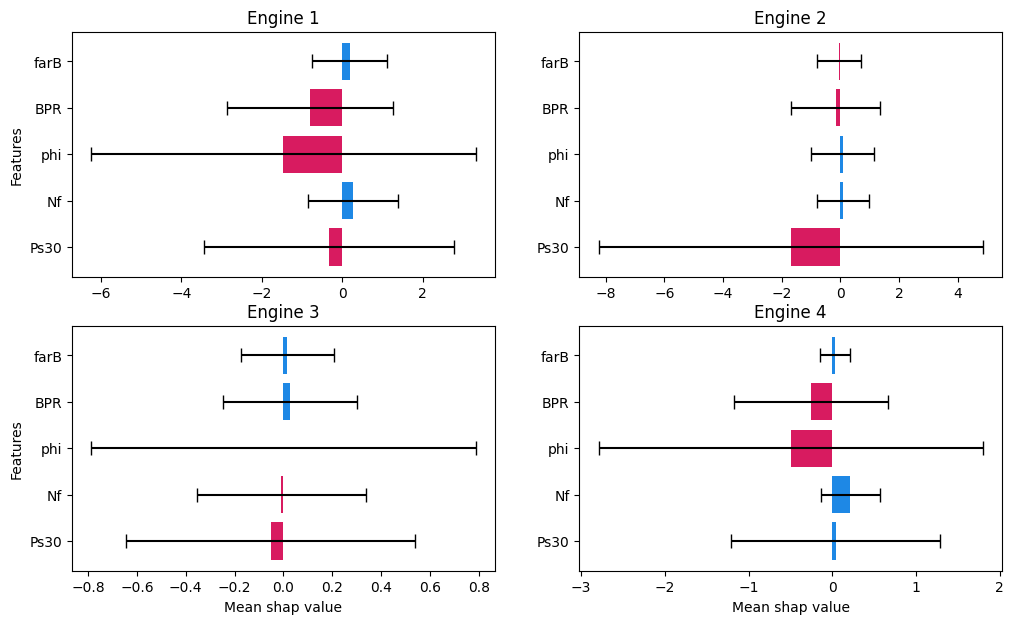

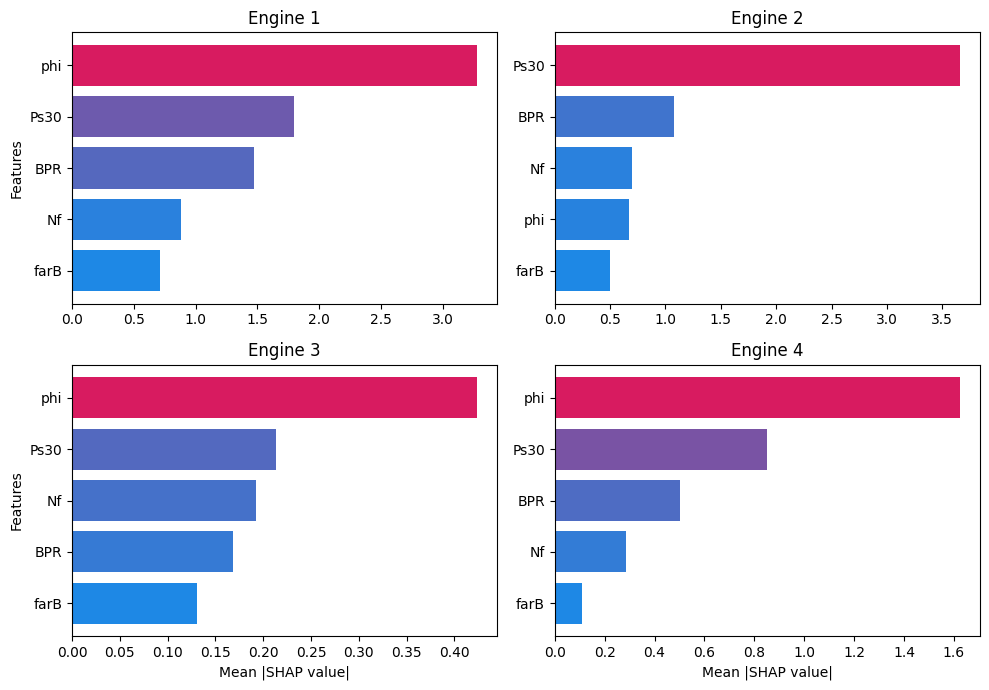

In [68]:
# Assuming you have a trained LSTM model and data
timesteps, features = train_array.shape[1], train_array.shape[2]

test_array_susbset = test_array[0:4]
test_array_susbset.shape

# Explain the LSTM model
shap_values, explainer = explain_lstm_model(model, train_array[:100], test_array_susbset, timesteps, features)

# Visualize SHAP values
# shap.summary_plot(shap_values, test_array_susbset.reshape(test_array_susbset.shape[0], -1))

# shap_values.shape
samples = shap_values.shape[0]
features = len(remaining_sensors)
list_of_shapes = [shap_values[i].reshape(-1,features) for i in range(samples)]


##explain with sign
# Calcul de la moyenne et de l'écart-type
lis_df_shap = []
for i, shap_values_2D in enumerate(list_of_shapes):
    # plt.subplot(2,2,i+1)
    shap_values_squeeze = shap_values_2D
    mean_shap = shap_values_squeeze.mean(axis=0)
    std_shap = shap_values_squeeze.std(axis=0)

    # Création des noms de variables
    column_names = remaining_sensors

    # DataFrame
    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap,
        "SHAP Std": std_shap
    })

    # Couleurs SHAP standards
    shap_blue = '#1E88E5'
    shap_red = '#D81B60'

    # Choix de la couleur selon le signe
    shap_df["Couleur"] = shap_df["SHAP Value"].apply(lambda x: shap_blue if x >= 0 else shap_red)
    lis_df_shap.append(shap_df)

plt.figure(figsize=(12, 7))
for kk, shap_df in enumerate(lis_df_shap):
    # print(kk)
    plt.subplot(2,2, kk+1)
    # Tracé des barres une par une avec la bonne couleur
    # plt.figure(figsize=(6, len(shap_df) * 0.6))
    for i, row in shap_df.iterrows():
        plt.barh(
            y=row["Variable"],
            width=row["SHAP Value"],
            xerr=row["SHAP Std"],
            color=row["Couleur"],
            # edgecolor='black',
            capsize=5
        )
    if kk>1:
        plt.xlabel("Mean shap value")
    if (kk+1)%2!=0:
        plt.ylabel("Features")
    plt.title(f"Engine {kk+1}")
    # plt.tight_layout()
plt.savefig("images/fd004_shape_std.png")
plt.show()

#explain without sign

# Dégradé bleu → rouge (faible → fort)
custom_cmap = LinearSegmentedColormap.from_list("shap_cmap", ['#1E88E5', '#D81B60'])

lis_df_shap = []
for i, shap_values_2D in enumerate(list_of_shapes):
    shap_values_squeeze = shap_values_2D
    mean_shap = np.abs(shap_values_squeeze).mean(axis=0)

    column_names = remaining_sensors

    shap_df = pd.DataFrame({
        "Variable": column_names,
        "SHAP Value": mean_shap
    })

    # Tri décroissant
    shap_df = shap_df.sort_values("SHAP Value", ascending=False).reset_index(drop=True)

    # Normalisation des valeurs entre 0 et 1 pour le dégradé
    norm = plt.Normalize(shap_df["SHAP Value"].min(), shap_df["SHAP Value"].max())
    shap_df["Couleur"] = [custom_cmap(norm(val)) for val in shap_df["SHAP Value"]]

    lis_df_shap.append(shap_df)

# Affichage
plt.figure(figsize=(10, 7))
for kk, shap_df in enumerate(lis_df_shap):
    plt.subplot(2, 2, kk + 1)

    for i, row in enumerate(shap_df.itertuples()):
        plt.barh(
            y=i,
            width=row._2,  # SHAP Value
            color=row.Couleur,
            #  height=0.6,
            # edgecolor='black'
        )

    # Axe Y
    plt.yticks(ticks=range(len(shap_df)), labels=shap_df["Variable"])
    plt.gca().invert_yaxis()

    if kk > 1:
        plt.xlabel("Mean |SHAP value|")
    if (kk + 1) % 2 != 0:
        plt.ylabel("Features")

    plt.title(f"Engine {kk + 1}")

plt.tight_layout()
plt.savefig("images/fd004_shape_abs.png")
plt.show()

In [69]:
# list_remaining_sensors = [remaining_sensors001, remaining_sensors002, remaining_sensors003, remaining_sensors004]
# list_somme_abs_par_feature = [somme_abs_par_feature001, somme_abs_par_feature002, somme_abs_par_feature003, somme_abs_par_feature004]

In [70]:
# # Convertir les données en DataFrame pour faciliter le tri
# plt.figure(figsize=(15, 12))
# for i in range(4) :
#     somme_abs_par_feature =list_somme_abs_par_feature[i]  # Somme sur samples et timesteps
#     remaining_sensors = list_remaining_sensors[i]
#     # print("Somme des valeurs absolues par feature :", somme_abs_par_feature)


#     df_features = pd.DataFrame({
#         "Feature": remaining_sensors,
#         "Importance": somme_abs_par_feature
#     })

#     # Trier les données par importance décroissante
#     df_features = df_features.sort_values(by="Importance", ascending=False)
#     plt.subplot(2,2, i+1)
#     # Création du barplot ordonné
#     sns.barplot(
#         x="Importance",
#         y="Feature",
#         data=df_features,
#         palette="viridis"
#     )
#     plt.xlabel(f"Features Importance According to SHAP for FD00{i+1} ")
#     plt.ylabel("Features")
#     plt.title("SHAP Features Importance (absolute Values)")
# plt.savefig('images/shap_valueall.png')
# plt.show()


In [71]:
!pip install pyALE

garder la facon de générer les explications

In [72]:
# # Dimensions originales
# samples = 1
# # timesteps = 30
# # features = 5

# # SHAP values aplaties (par exemple après un Bar Plot ou un LIME)
# shap_values_flat = np.random.rand(samples, timesteps * features)

# # Dimensions originales des données
# original_shape = (samples, timesteps, features)

# # Reshape des SHAP values
# shap_values_reshaped = reshape_shap_values(shap_values_flat, original_shape)
# print("Shape reshaped:", shap_values_reshaped.shape)  # Devrait donner (100, 30, 5)

# list_shap_values = []
# for i in range(samples):
#     shap_values_2D = shap_values[i].reshape(-1,features)
#     list_shap_values.append(np.abs(shap_values_2D).sum(axis=0))  # Somme sur samples et timesteps
# somme_abs_par_feature001 = np.array(list_shap_values).sum(axis = 0)
# remaining_sensors001 = remaining_sensors
# somme_abs_par_feature001